In [1]:
!pip install optuna
!pip install catboost
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 20.4 MB/s e

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tuning
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Modelling
import catboost as cb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from pycaret.classification import ClassificationExperiment
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Overview Data

## Train Data

In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## Test Data

In [7]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [9]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# Exploratory Data Analysis

### check duplicate

In [10]:
df_train[df_train.duplicated()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


### Missing Values

In [11]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

I assume VIP passengers are the rich people. Then I will also assume that they will spend more in luxury amenities (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck). 

My propose solution for these columns are:
- non vip: fillna with non-vip mean
- vip: fillna with vip mean

In [12]:
def fillna_luxury_amenities(df):
    luxury_amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df = df.copy()
    for col in luxury_amenities:
        # VIP
        df.loc[(df['VIP']==True) & (df[col].isna()), col] = df.loc[df['VIP']==True, col].mean()
        # non VIP
        df.loc[(df['VIP']==False) & (df[col].isna()), col] = df.loc[df['VIP']==False, col].mean()
    return df

def fillna_cabin(row):
    values = df_train['Cabin'].dropna().unique()
    if pd.isnull(row):
        return np.random.choice(values)
    else:
        return row
    
# main function for fill missing values
def fill_missing_values(df):
    df = df.copy()
    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode().iloc[0])
    df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode().iloc[0])
    df['Destination'] = df['Destination'].fillna(df['Destination'].mode().iloc[0])
    df['VIP'] = df['VIP'].fillna(df['VIP'].mode().iloc[0])
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Cabin'] = df['Cabin'].apply(fillna_cabin)
    df = fillna_luxury_amenities(df)
    df['Name'] = df['Name'].fillna("unknown")
    return df

In [13]:
df_train = fill_missing_values(df_train)
df_test = fill_missing_values(df_test)

In [14]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### some visualization

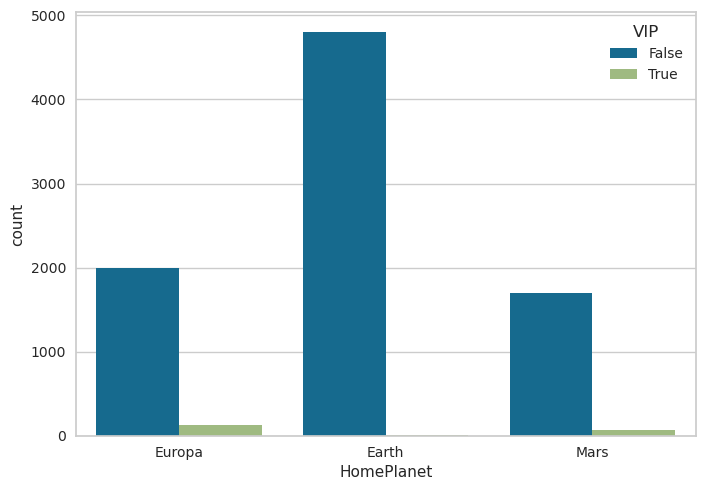

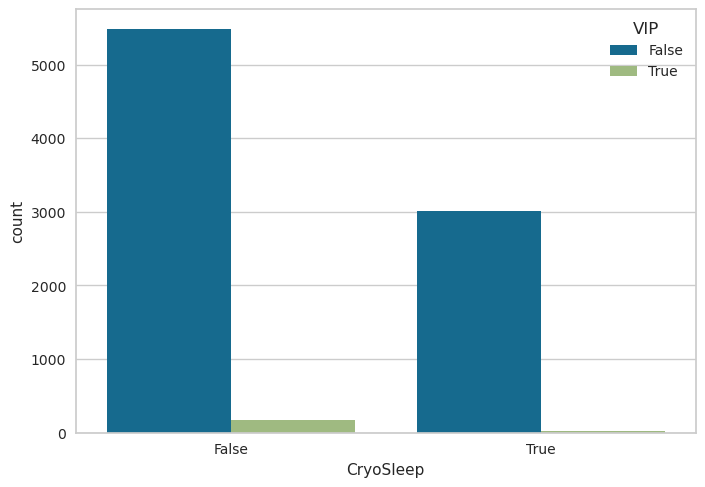

In [15]:
cols = ['HomePlanet', 'CryoSleep']
for col in cols:
    sns.countplot(data=df_train, x=col, hue='VIP')
    plt.show()

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

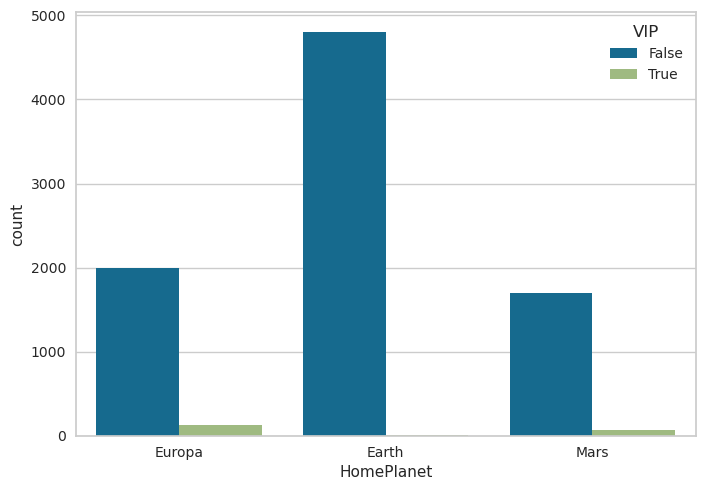

In [16]:
sns.countplot(data=df_train, x='HomePlanet', hue='VIP')

<Figure size 500x500 with 0 Axes>

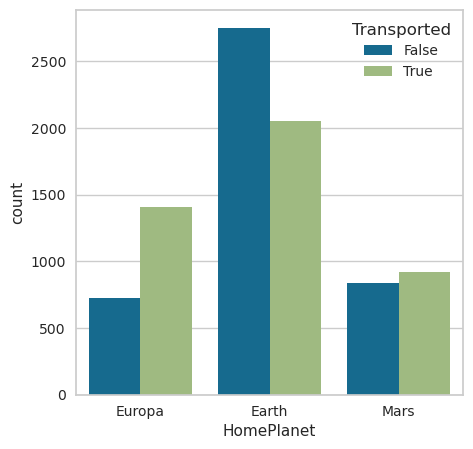

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

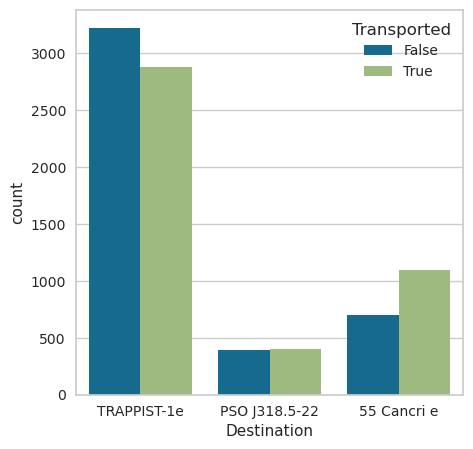

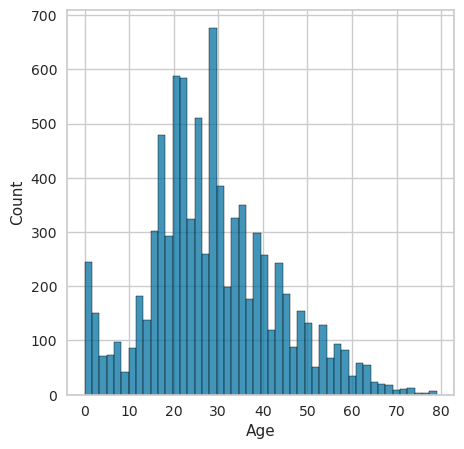

<Figure size 500x500 with 0 Axes>

<AxesSubplot:ylabel='Density'>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

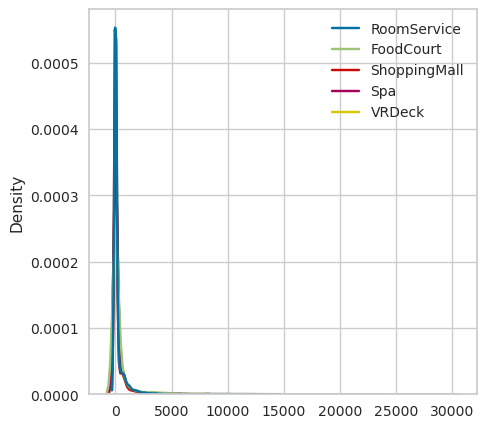

In [17]:
cols = [col for col in df_train.columns if col !='Transported']
skip = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerId', 'Name', 'Cabin']

for col in cols:
    plt.figure(figsize=(5,5))
    if col in skip:
        continue
    elif df_train[col].dtypes==object:
        sns.countplot(data=df_train, x=col, hue='Transported')
    elif df_train[col].dtypes==float:
        sns.histplot(df_train[col])
    plt.show()
data = df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
sns.kdeplot(data=data)

# Feature Engineering

In [18]:
df_train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


## Transform Data

In [19]:
def transform_cryosleep(row):
    if row==False:
        return 0
    else:
        return 1
    
def transform_vip(row):
    if row==False:
        return 0
    else:
        return 1
    
# create new feature: group, it will be extracted from the 4 first id in PassengerId
def extract_group(df):
    df = df.copy()
    df['group'] = df['PassengerId'].str.split("_").str.get(0)
    df['group'] = df['group'].astype(int)
    return df

# transform cabin column into its own value (deck, num, side)
def transform_cabin(df):
    df = df.copy()
    cabin = df['Cabin'].str.split("/", expand=True)
    cabin.columns = ['cabin_deck', 'cabin_num', 'cabin_side']
    cabin['cabin_num'] = cabin['cabin_num'].astype(int)
    df = pd.concat([df, cabin], axis=1)
    df = df.drop('Cabin', axis=1)
    return df
    
def transform(df):
    df = df.copy()
    df['CryoSleep'] = df['CryoSleep'].apply(transform_cryosleep)
    df['VIP'] = df['VIP'].apply(transform_vip)
    df = extract_group(df)
    df = transform_cabin(df)
    return df

In [20]:
df_train = transform(df_train)
df_test = transform(df_test)

In [21]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group,cabin_deck,cabin_num,cabin_side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1,S


## Encoding and Scaling

### one hot encoding

In [22]:
def one_hot_encoding(df):
    df = df.copy()
    ohe_cols = ['HomePlanet', 'Destination', 'cabin_side', 'cabin_deck']
    df_encoded = pd.get_dummies(df, columns=ohe_cols)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=ohe_cols, axis=1)
    return df

In [23]:
df_train = one_hot_encoding(df_train)
df_test = one_hot_encoding(df_test)

### Min Max Scaling

In [24]:
from sklearn.preprocessing import MinMaxScaler

def minmax_scaling(df):
    df = df.copy()
    scaling_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    scaler = MinMaxScaler()
    df[scaling_cols] = scaler.fit_transform(df[scaling_cols])
    return df

In [25]:
df_train = minmax_scaling(df_train)
df_test = minmax_scaling(df_test)

### Set PassengerId as Index

In [26]:
df_train.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'group',
       'cabin_num', 'PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'group', 'cabin_num', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'cabin_side_P',
       'cabin_side_S', 'cabin_deck_A', 'cabin_deck_B', 'cabin_deck_C',
       'cabin_deck_D', 'cabin_deck_E', 'cabin_deck_F', 'cabin_deck_G',
       'cabin_deck_T'],
      dtype='object')

remove duplicated columns

In [27]:
df_train = df_train.loc[:,~df_train.columns.duplicated()].copy()
df_test = df_test.loc[:,~df_test.columns.duplicated()].copy()

In [28]:
df_train.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'group',
       'cabin_num', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'cabin_side_P', 'cabin_side_S',
       'cabin_deck_A', 'cabin_deck_B', 'cabin_deck_C', 'cabin_deck_D',
       'cabin_deck_E', 'cabin_deck_F', 'cabin_deck_G', 'cabin_deck_T'],
      dtype='object')

In [29]:
df_train = df_train.set_index('PassengerId')
df_test = df_test.set_index('PassengerId')

In [30]:
df_train.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,cabin_side_P,cabin_side_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,0.493671,0,0.000000,0.000000,0.000000,0.00000,0.000000,Maham Ofracculy,False,...,1,0,0,1,0,0,0,0,0,0
0002_01,0,0.303797,0,0.007608,0.000302,0.001064,0.02450,0.001823,Juanna Vines,True,...,0,1,0,0,0,0,0,1,0,0
0003_01,0,0.734177,1,0.003001,0.119948,0.000000,0.29967,0.002030,Altark Susent,False,...,0,1,1,0,0,0,0,0,0,0


In [31]:
df_test.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,group,...,cabin_side_P,cabin_side_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,1,0.341772,0,0.0,0.000000,0.0,0.00000,0.0,Nelly Carsoning,13,...,0,1,0,0,0,0,0,0,1,0
0018_01,0,0.240506,0,0.0,0.000356,0.0,0.14226,0.0,Lerome Peckers,18,...,0,1,0,0,0,0,0,1,0,0
0019_01,1,0.392405,0,0.0,0.000000,0.0,0.00000,0.0,Sabih Unhearfus,19,...,0,1,0,0,1,0,0,0,0,0


### Transform Target Variable into Numerical (Transported)

In [32]:
def transform_transported(row):
    if row==True:
        return 1
    else:
        return 0

In [33]:
df_train['Transported'] = df_train['Transported'].apply(transform_transported)
df_train.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,cabin_side_P,cabin_side_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,0.493671,0,0.000000,0.000000,0.000000,0.00000,0.000000,Maham Ofracculy,0,...,1,0,0,1,0,0,0,0,0,0
0002_01,0,0.303797,0,0.007608,0.000302,0.001064,0.02450,0.001823,Juanna Vines,1,...,0,1,0,0,0,0,0,1,0,0
0003_01,0,0.734177,1,0.003001,0.119948,0.000000,0.29967,0.002030,Altark Susent,0,...,0,1,1,0,0,0,0,0,0,0


# Modelling

In [34]:
df_train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Name', 'Transported', 'group', 'cabin_num',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'cabin_side_P', 'cabin_side_S',
       'cabin_deck_A', 'cabin_deck_B', 'cabin_deck_C', 'cabin_deck_D',
       'cabin_deck_E', 'cabin_deck_F', 'cabin_deck_G', 'cabin_deck_T'],
      dtype='object')

In [35]:
# not in features 1
skip = ['Name', 'Transported']

# not in features 2
skip2 = skip + [col for col in df_train.columns if col.startswith('Destination')]
skip2 = skip2 + [col for col in df_train.columns if col.startswith('HomePlanet')]

# not in features 3
skip3 = skip2 + [col for col in df_train.columns if col.startswith('cabin')]

# not in features 4
skip4 = skip2 + [col for col in df_train.columns if col not in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

In [36]:
features = [col for col in df_train.columns if col not in skip]
features2 = [col for col in df_train.columns if col not in skip2]
features3 = [col for col in df_train.columns if col not in skip3]
features4 = [col for col in df_train.columns if col not in skip4]

target = 'Transported'

In [37]:
X_train, X_val, y_train, y_val = train_test_split(df_train[features2], df_train[target], test_size=0.2)

## PyCaret (Base Model Comparison)

In [38]:
# exp = ClassificationExperiment()
# exp.setup(df_train, target='Transported', session_id=123)

In [39]:
# compare baseline model
# exp.compare_models()

## Optuna (Hyperparameter Tuning)

In [40]:
X = df_train[features2]
y = df_train[target]

kfolds = KFold(n_splits=5, shuffle=True, random_state=123)

In [41]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

### Logistic Regression

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [43]:
def logreg_objective(trial):
    _tol = trial.suggest_float("tol", 1e-6, 1e-1)
    lr = LogisticRegression(tol=_tol, random_state=123)
    scores = cross_val_score(
        lr,
        X, y,
        cv=kfolds,
        scoring="neg_root_mean_squared_error"
    )
    return scores.mean()

# lr_params = tune(logreg_objective)
# lr = LogisticRegression(**lr_params, random_state=123)
# lr.fit(X_train, y_train)

### Catboost Classifier

In [44]:
cbc = cb.CatBoostClassifier(learning_rate=0.005, depth=10)
cbc.fit(X_train, y_train, verbose=0)

In [45]:
params = {
    'learning_rate': [0.001, 0.005, 0.03, 0.1],
    'depth': [4, 6, 10, 15],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# grid_search_result = cbc.grid_search(
#     params,
#     X=X_train,
#     y=y_train,
#     cv=5,
#     verbose=False
# )

In [46]:
def cbc_objective(trial):
    _learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-1)
    _depth = trial.suggest_int("depth", 4, 20)
    cbc = cb.CatBoostClassifier(
        learning_rate=_learning_rate, 
        
        random_state=123
    )
    scores = cross_val_score(
        cbc,
        X, y,
        cv=kfolds,
        scoring="neg_root_mean_squared_error"
    )
    return scores.mean()

# cbc_params = tune(cbc_objective)
# cbc = CatBoostClassifier(**cbc_params, random_state=123)
# cbc.fit(X_train, y_train, verbose=0)

### XGBoost Classifier

In [47]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Random Forest Classifier

In [48]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

## Evaluation data_val

In [49]:
def evaluation(y_pred, y_true):
    print(f'accuracy: {accuracy_score(y_true, y_pred)}\n\n')
    print(f'confusion matrix:\n{confusion_matrix(y_true, y_pred)}\n\n')
    print(f'classification report:\n{classification_report(y_true, y_pred)}')

In [50]:
y_pred_lr = lr.predict(X_val)

print("Logistic Regression (tuned with optuna)")
evaluation(y_pred_lr, y_val)

Logistic Regression (tuned with optuna)
accuracy: 0.7251293847038528


confusion matrix:
[[688 147]
 [331 573]]


classification report:
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       835
           1       0.80      0.63      0.71       904

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.72      1739
weighted avg       0.74      0.73      0.72      1739



In [51]:
y_pred_cbc = cbc.predict(X_val)

print("Catboost Classifier")
evaluation(y_pred_cbc, y_val)

Catboost Classifier
accuracy: 0.8159861989649224


confusion matrix:
[[662 173]
 [147 757]]


classification report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       835
           1       0.81      0.84      0.83       904

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739



In [52]:
y_pred_xgbc = xgbc.predict(X_val)

print("XGBoost Classifier")
evaluation(y_pred_xgbc, y_val)

XGBoost Classifier
accuracy: 0.8039102932719954


confusion matrix:
[[673 162]
 [179 725]]


classification report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       835
           1       0.82      0.80      0.81       904

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [53]:
y_pred_rfc = rfc.predict(X_val)

print("Random Forest Classifier")
evaluation(y_pred_rfc, y_val)

Random Forest Classifier
accuracy: 0.7947096032202415


confusion matrix:
[[692 143]
 [214 690]]


classification report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       835
           1       0.83      0.76      0.79       904

    accuracy                           0.79      1739
   macro avg       0.80      0.80      0.79      1739
weighted avg       0.80      0.79      0.79      1739



# Submission

In [54]:
y_pred = cbc.predict(df_test[features2])

prediction = pd.DataFrame({
    'PassengerId': df_test.index,
    'Transported': y_pred
})

In [55]:
def transform_result(row):
    if row==1:
        return True
    return False

In [56]:
prediction['Transported'] = prediction['Transported'].apply(transform_result)
prediction.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [57]:
prediction.to_csv('submission.csv', index=False)